## Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler,MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)
import csv
from sklearn.linear_model import LinearRegression

## Thu thập dữ liệu

In [2]:
# Đọc dữ liệu từ "data.csv"
df = pd.read_csv('data_better_distribution.csv')
df.head()

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29
1,2200.0,Single Family Residential,4,2.0,4234.0,3,260000,Forced Air (Natural Gas),Central A/C,NaN,Bungalow,1915.0,NaN,Chicago,1119 North Lockwood Avenue,2938.45
2,750.0,Condo/Coop,2,NaN,NaN,1,275000,Forced Air (Natural Gas),Central A/C,NaN,Other,1926.0,NaN,Chicago,1100 North Paulina Street #1M,4722.00
3,1248.0,Single Family Residential,3,2.0,5279.0,2,309900,NaN,Central A/C,NaN,Ranch,1962.0,NaN,Chicago,4909 North Normandy Avenue,560.03
4,1337.0,Single Family Residential,3,2.0,NaN,2,324900,Forced Air (Natural Gas),Central A/C,NaN,Georgian,1949.0,NaN,Chicago,10034 South Artesian Avenue,77.40


---

## Khám phá dữ liệu (để làm rõ câu hỏi)

### Số dòng và cột

In [3]:
df.shape

(1626, 16)

### Ý nghĩa của từng dòng. Có dòng nào không phù hợp không?

Mỗi dòng thể hiện 17 thông tin khác nhau của một căn nhà được giao bán. Do dữ liệu được lấy trong trang mô tả chi tiết của từng căn nhà nên sẽ không có dòng nào đặc biệt.

Tuy nhiên người đăng có thể giao bán 1 căn nhà nhiều lần, các dòng có thể bị lặp lại.

### Kiểm tra số dòng bị lặp lại

In [4]:
df.duplicated().sum()

48

$\to$ Bỏ đi các dòng duplicates

In [5]:
df = df.drop_duplicates()

### Ý nghĩa của mỗi cột

In [6]:
df.head(1)

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29


**Ý nghĩa của từng cột** 
- `beds` : Số phòng ngủ
- `baths` : Số phòng vệ sinh
- `house_type` : Loại hình nhà ở
- `sqlt` : Diện tích căn nhà
- `parkingSpots`: chỗ đỗ xe
- `address` : Địa chỉ của căn nhà
- `listPrice `: Giá tiền hiện giao bán
- `lotSize`: diện tích sử dụng
- `heating system`: hệ thống giữ nhiệt
- `cooling system`: hệ thống làm lạnh
- `view_type`: view của căn nhà
- `architecture_style`: phong cách thiết kế
- `yearBuilt`: năm xây dựng
- `has_pool`: số lượng hồ bơi
- `city`: thành phố
- `tax`: tiền thuế

### Làm rõ câu hỏi

**Câu hỏi đưa ra:** Với một căn nhà mơ ước, người khách hàng cần bao nhiêu tiền để có thể mua được ở bang Chicago của Mỹ ? 

Tạm thời các cột Input sẽ là thông tin liên quan tới căn nhà được giao bán, tổng cộng có 15 cột. Cột Output sẽ là giá bán của ngôi nhà. Nhóm sẽ sử dụng mô hình hồi quy để dự đoán giá nhà (cột Output) dựa trên thông tin của căn nhà (cột Input).

Các cột Input có thể thay đổi ở các bước tiền xử lý sau.

**Lợi ích khi trả lời**: 

Có thể đưa ra một mức giá sấp xỉ để những người trẻ có thể dựa vào đó để nổ lực phấn đấu mua được căn nhà mình muốn.

## Khám phá dữ liệu (để tách các tập)


Để biết cách tách các tập thì cần khám phá thêm tập output:
- Cột này hiện có kiểu dữ liệu là gì? Đối với bài toán hồi quy, cột output cần có kiểu dữ liệu dạng số
- Cột này có giá trị thiếu không? Nếu có giá trị thiếu thì cần loại bỏ trước khi tách tập
- Phân phối cột output như thế nào?

In [7]:
# Kiểu dữ liệu cột output
df['listPrice'].dtype

dtype('int64')

In [8]:
# Có giá trị nào thiếu không?
df['listPrice'].isna().sum()

0

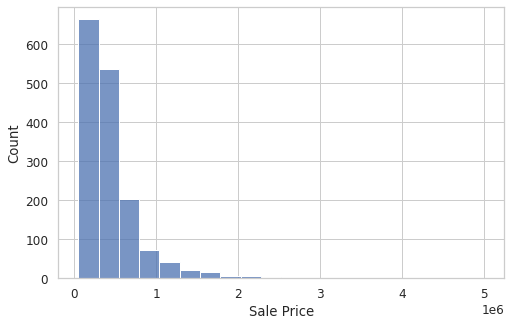

In [9]:
# Biểu đồ histogram của cột output
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.histplot(data =  df['listPrice'], bins=20).set(xlabel='Sale Price', ylabel='Count');

**Nhận xét từ biểu đồ**:
- Có xuất hiện outliers, làm cho khoảng cách giữa min và max quá lớn 
- Dữ liệu phân bố không đều, tập trung nhiều vào khoảng < 1000000$\$$ 

**Kết luận**:
- Sẽ xử lí outliers cho tập Train để mô hình học không bị ảnh hưởng bởi nhiễu 

---

### Tiền xử lý tách tập dữ liệu

In [10]:
# Tách X và y
y = df["listPrice"] 
X = df.drop("listPrice", axis=1)

Tách tập huấn luyện và tập validation và tập test theo tỉ lệ **60:20:20**

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                               test_size=0.2)

In [12]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                               test_size=0.25) # 0.25*0.8 = 0.2

In [13]:
print("train_X.shape: ", train_X.shape)
print("train_y.shape: ", train_y.shape)

print("val_X.shape: ", val_X.shape)
print("val_y.shape: ", val_y.shape)

print("test_X.shape: ", test_X.shape)
print("test_y.shape: ", test_y.shape)

train_X.shape:  (946, 15)
train_y.shape:  (946,)
val_X.shape:  (316, 15)
val_y.shape:  (316,)
test_X.shape:  (316, 15)
test_y.shape:  (316,)


---

## Khám phá dữ liệu (trên tập train)

### Kiểu dữ liệu từng cột. Có cột nào chưa phù hợp?

In [14]:
train_X.dtypes

sqft                  float64
homeType               object
beds                    int64
parkingSpots          float64
lotSize               float64
baths                   int64
heating_system         object
cooling_system         object
view_type             float64
architecture_style     object
yearBuilt             float64
has_pool               object
city                   object
address                object
tax                   float64
dtype: object

**Nhận xét**: Tất cả các cột trên đều có kiểu dữ liệu phù hợp

### Các cột dạng numerical phân bố như thế nào?

In [15]:
train_X.dtypes[train_X.dtypes != object]

sqft            float64
beds              int64
parkingSpots    float64
lotSize         float64
baths             int64
view_type       float64
yearBuilt       float64
tax             float64
dtype: object

In [16]:
num_cols = ['sqft',"beds","parkingSpots","lotSize","baths","view_type","yearBuilt","tax"]
num_df = train_X[num_cols]
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
def lower_quartile(c):
    return c.quantile(0.25).round(1)
def upper_quartile(c):
    return c.quantile(0.75).round(1)

num_df.agg([missing_percentage, 'min',lower_quartile, median,upper_quartile, 'max'])

,sqft,beds,parkingSpots,lotSize,baths,view_type,yearBuilt,tax
missing_percentage,20.4,0.0,16.6,53.2,0.0,100.0,9.5,5.5
min,470.0,0.0,0.0,0.0,1.0,NaN,1868.0,77.4
lower_quartile,1079.0,2.0,1.0,3136.0,2.0,NaN,1924.0,2375.1
median,1411.0,3.0,2.0,3781.0,2.0,NaN,1958.0,4283.1
upper_quartile,2000.0,4.0,2.0,5009.0,3.0,NaN,2001.0,8006.3
max,7600.0,4.0,100.0,5225894.0,5.0,NaN,2022.0,730774.0


**Nhận xét**: 
- Cột "view_type" không có giá trị nào, không có ý nghĩa $\to$ Loại bỏ
- Cột "lotSize" có tỷ lệ thiếu quá lớn (khoảng 40%) $\to$ Loại bỏ
- Khoảng cách giữa min và max quá lớn (cột "tax","parkingSpot") $\to$ Có thể do outliers 

### Các cột dạng categorical phân bố như thế nào?

In [17]:
train_X.dtypes[train_X.dtypes == object]

homeType              object
heating_system        object
cooling_system        object
architecture_style    object
has_pool              object
city                  object
address               object
dtype: object

In [18]:
cate_cols = list(set(train_X.columns) - set(num_cols))
cate_df = train_X[cate_cols]
pd.set_option('display.max_colwidth', 200)
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
cate_df.agg([missing_percentage, num_values, value_percentages])

,cooling_system,has_pool,architecture_style,address,city,heating_system,homeType
missing_percentage,1.0,97.6,0.0,0.0,0.0,27.2,0.0
num_values,4,1,15,944,1,24,4
value_percentages,"{'Central A/C': 77.7, 'Window Unit(s) A/C': 11.3, 'None': 10.8, 'Zoned A/C': 0.2}",{True: 100.0},"{'Other': 65.9, 'High Rise': 9.6, 'Ranch': 6.6, 'Bungalow': 6.4, 'Loft': 2.9, 'Cape Cod': 1.9, 'Georgian': 1.8, 'Contemporary': 1.0, 'New Traditional': 0.8, 'Cottage': 0.7, 'Split Level': 0.6, 'En...","{'1512 West Chestnut Street #2': 0.2, '420 East Waterside Drive #1403': 0.2, '6610 North California Avenue #2S': 0.1, '6875 North Northwest Highway #2D': 0.1, '1815 North Fremont Street': 0.1, '42...",{'Chicago': 100.0},"{'Forced Air (Natural Gas)': 59.9, 'Fireplace (Natural Gas)': 11.0, 'Forced Air': 6.7, 'Hot Water': 3.3, 'Baseboard': 3.0, 'Baseboard (Natural Gas)': 2.9, 'Radiator': 2.6, 'Hot Water (Natural Gas)...","{'Condo/Coop': 50.6, 'Single Family Residential': 48.0, 'Townhouse': 0.7, 'Other': 0.6}"


**Nhận xét**:
- Cột "has_pool" có tỷ lệ thiếu quá lớn > 80% $\to$ Loại bỏ
- Cột "city" chỉ có 1 giá trị, không có tác động với mô hình $\to$ Loại bỏ
- Giá trị của các cột đều không có thứ tự 
- Cột "address" có quá nhiều giá trị phân biệt $\to$ Thử lấy tên đường

#### Tiền xử lí cột Address (tách tên đường)

In [19]:
street_col = train_X["address"].str.extract('(?P<number>\d+)(?P<Street>.*)')
street_col = street_col.Street.str.split("#").str[0]
street_col = street_col.str.strip()
street_col.agg([num_values, value_percentages]).to_frame()

,Street
num_values,594
value_percentages,"{'North Lake Shore Drive': 1.6, 'South State Street': 1.1, 'North Sheridan Road': 0.8, 'South Green Street': 0.7, 'East Delaware Place': 0.7, 'North Halsted Street': 0.7, 'North Paulina Street': 0..."


Có nhiều giá trị rời rạc trong cột "street_col", và phần trăm đóng góp từng giá trị quá nhỏ \
$\to$ Bỏ cột "address"

### Mối quan hệ các cột input với cột output

#### Mối quan hệ giữa output và numerical columns

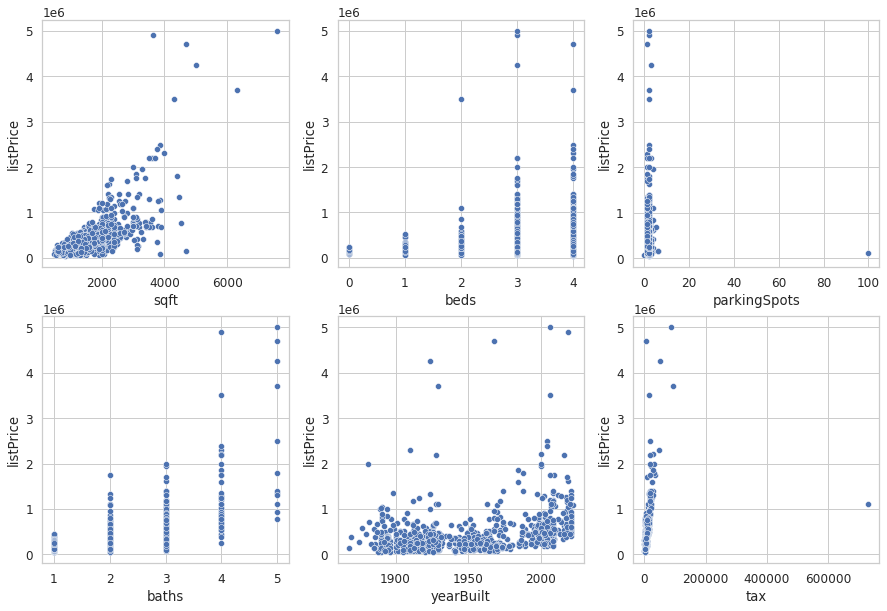

In [20]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))
num_df = num_df.drop(columns=["lotSize","view_type"])
for var, subplot in zip(num_df, ax.flatten()):
    sns.scatterplot(x=train_X[var],y=train_y, ax=subplot);

**Nhận xét biểu đồ:**
- Do xuất hiện outliers với khoảng cách quá xa nên ở các cột "parkingSpot","tax" thì dữ liệu bị chụm lại một phía
- Từ biểu đồ, có thể thấy yearBuilt và listPrice không có mối quan hệ nào với nhau

**Kết luận**:
- Loại bỏ cột "yearBuilt"
- Thực hiện loại bỏ outliers cho các cột numerical

#### Mối quan hệ giữa output và categorical columns

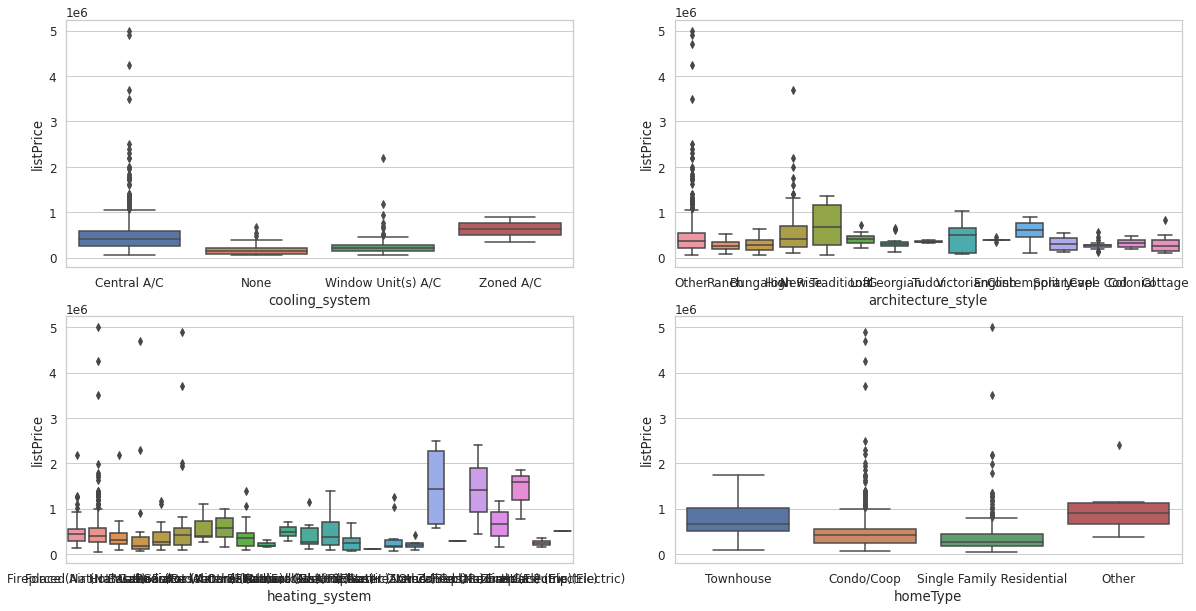

In [21]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
cate_df = cate_df.drop(columns=["city","address","has_pool"])
for var, subplot in zip(cate_df, ax.flatten()):
    sns.boxplot(x=train_X[var],y=train_y, ax=subplot)

## Tiền xử lý tập train

### Loại bỏ outliers khỏi tập Train

**Phương pháp loại bỏ**: sử dụng độ lệch chuẩn (standard deviation) \
Dựa trên [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) \
Giữ lại 99.7% dữ liệu với công thức $\mu-3\sigma \leq X \leq \mu+3\sigma$
- $\mu$ là giá trị trung bình 
- $\sigma$ là độ lệch chuẩn

In [22]:
outliers_index = set()
_cols = ['sqft',"beds","parkingSpots","baths","tax","listPrice"]

def outliers_removed(col):
    if col.name in _cols:
        data_std = col.std()    
        data_mean = col.mean()
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        outliers_removed = (col < lower) | (col > upper)
        outliers_index.update(set(col[outliers_removed].index.values))
    return col

train_X.apply(outliers_removed)
print()
outliers_removed(train_y) 

train_X = train_X.drop(list(outliers_index))
train_y = train_y.drop(list(outliers_index))

### Cột dạng numerical

- Điền các giá trị thiếu là bằng cách sử dụng median 
- Các cột cần phải loại bỏ là lotSize, view_type, yearBuilt \
$\to$ Các cột numerical còn lại: `sqft`,`beds`,`parkingSpots`,`baths`,`tax`

#### Đối với các cột numerical sau khi loại bỏ nhiễu

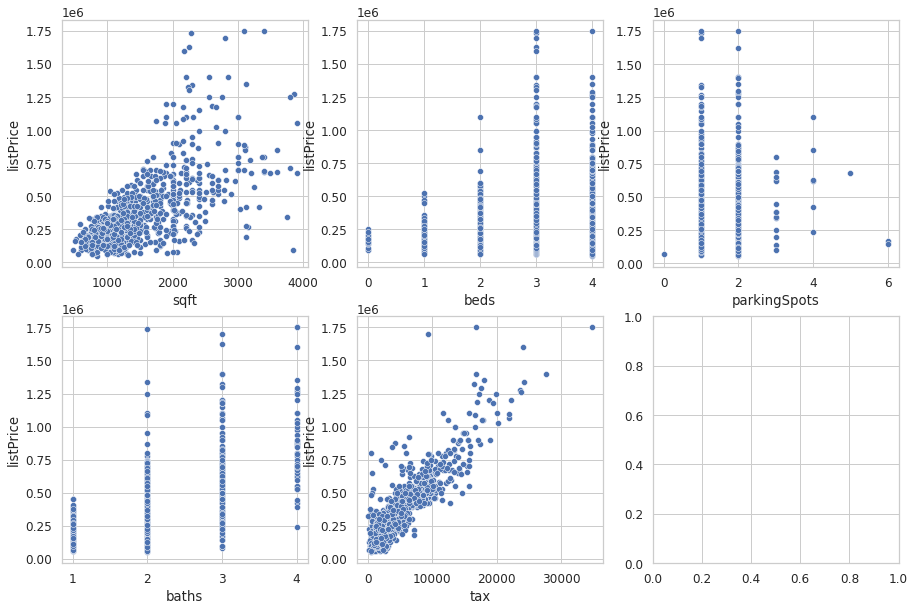

In [23]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))
num_df = num_df.drop(columns=["yearBuilt"])
for var, subplot in zip(num_df, ax.flatten()):
    sns.scatterplot(x=train_X[var],y=train_y, ax=subplot);

**Nhận xét biểu đồ:**
- Cột "sqft" và "tax" thể hiện rõ mối quan hệ tuyến tính với cột output
- Cột "parkingSpots" không có mối quan hệ cụ thể $\to$ Loại bỏ

In [24]:
class NumeDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        # bỏ cột      
        self.newX_df=self.newX_df.drop(columns=["lotSize","view_type","yearBuilt","parkingSpots"])
        return self.newX_df

### Cột dạng categorical

- Điền các giá trị thiếu bằng most-frequent
- Các cột sẽ được loại bỏ: city, has_pool, address
- heating_system, home_type, architecture_type, cooling_system sẽ được chuyển thành dạng one-hot

In [25]:
def fit_col(X, num_top_titles):
    self = X.value_counts()
    index = list(self.index)
    self = index[:max(1, min(num_top_titles, len(index)))]
    return self

def transform_col(self, X):
    return np.where(X.isin(self),X,"Other")

In [26]:
class CateDropper(BaseEstimator, TransformerMixin):
    def __init__(self, n=1):
        self.n = n
        self.top_cols = ["heating_system", "homeType", "architecture_style", "cooling_system"]
    def fit(self, X, y=None):
        self.heat_counts = fit_col(X.heating_system, self.n )
        self.homeType = fit_col(X.homeType,self.n)
        self.architecture_style = fit_col(X.architecture_style,self.n)
        self.cooling_system = fit_col(X.cooling_system,self.n)
        
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        
        self.newX_df["heating_system"] = transform_col(self.heat_counts, self.newX_df["heating_system"])
        self.newX_df["homeType"] = transform_col(self.homeType, self.newX_df["homeType"])
        self.newX_df["architecture_style"] = transform_col(self.architecture_style, self.newX_df["architecture_style"])
        self.newX_df["cooling_system"] = transform_col(self.cooling_system, self.newX_df["cooling_system"])

        # bỏ cột       
        self.newX_df=self.newX_df.drop(columns=["has_pool","city","address"])
        return self.newX_df

#### Đối với các cột categorical sao khi loại bỏ nhiễu

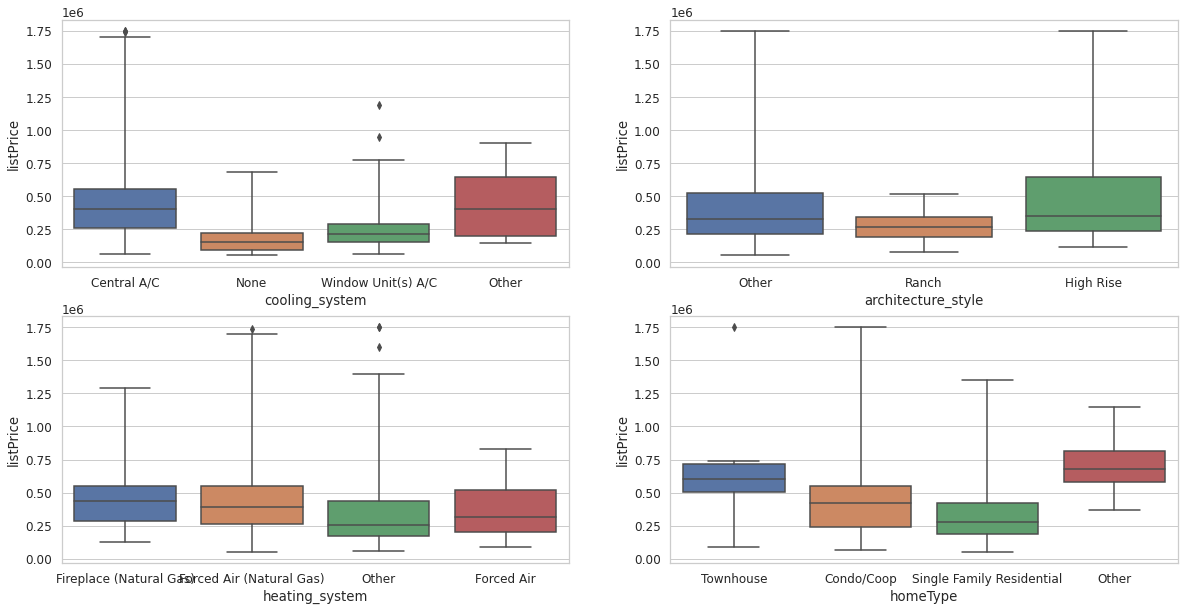

In [27]:
orginial_X = train_X.copy()
orginial_Y = train_y.copy()
col_cateDropper = CateDropper(n=3)
orginial_X = col_cateDropper.fit_transform(orginial_X)

fig, ax = plt.subplots(2,2, figsize=(20, 10))
for var, subplot in zip(cate_df, ax.flatten()):
    g=sns.boxplot(x=orginial_X[var],y=orginial_Y, ax=subplot,whis=4)

### Toàn bộ quá trình xử lý sẽ được thực hiện như sau:
- Xử lý các cột dạng số: bỏ đi lotSize và view_type và yearBuilt, điền các giá trị thiếu bằng median, loại bỏ outlier
- Xử lý các cột dạng categorical: bỏ đi has_pool, address, city. Điền các giá trị thiếu bằng most-frequent, lấy top N giá trị xuất hiện nhiều nhất của các cột còn lại, chuyển thành Onehot

In [28]:
num_cols = ["sqft", "beds" , "baths","tax"]
cate_cols = ["homeType", "heating_system", "cooling_system","architecture_style" ]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))])


categotical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('nume', numeric_transformer, num_cols),
        ('cate',categotical_transformer , cate_cols)])


preprocess_pipeline = Pipeline(steps=[('numdropper',NumeDropper()),
                                      ('catedropper', CateDropper(n=3)),
                                      ('preprocessor', preprocessor),
                                      ('minmax', MaxAbsScaler())])

preprocess_pipeline

Pipeline(steps=[('numdropper', NumeDropper()),
                ('catedropper', CateDropper(n=3)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('nume',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['sqft', 'beds', 'baths',
                                                   'tax']),
                                                 ('cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['homeType', 'heating_system',
                                                   'cooling_system',
                                                   'architecture_style'])])),
                ('minmax', MaxAbsScaler())])

## Mô hình hóa

#### Hàm tính RR
Nguồn: Bài 07-Demo.ipynb của thầy Trần Trung Kiên

In [29]:
def compute_mse(y, preds):
    return ((y - preds)**2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)
baseline_preds = test_y.mean()

### MLPRegressor

#### Full pipeline

In [30]:
model = MLPRegressor(solver='sgd', 
                    activation = 'relu',
                    hidden_layer_sizes=(30,10), 
                    random_state=None,
                    max_iter = 3000,
                    alpha=1e-5)
full_pipeline = Pipeline(steps=[('preprocess_pipeline', preprocess_pipeline),
                                 ('neural_network',model)])
full_pipeline

Pipeline(steps=[('preprocess_pipeline',
                 Pipeline(steps=[('numdropper', NumeDropper()),
                                 ('catedropper', CateDropper(n=3)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('nume',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['sqft',
                                                                    'beds',
                                                                    'baths',
                                                                    'tax']),
                                                                  ('cate',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['homeType',
                                                                    'heating_system',
                                                                    'cooling_system',
                                                                    'architecture_style'])])),
                                 ('minmax', MaxAbsScaler())])),
                ('neural_network',
                 MLPRegressor(alpha=1e-05, hidden_layer_sizes=(30, 10),
                              max_iter=3000, solver='sgd'))])

#### Normalize output

- Cần chuẩn hóa cột output vì cột Input đã được chuẩn hóa, để đảm bảo cho trọng số mô hình sau khi huấn luyện không quá lớn (vì quá lớn mô hình không ổn định) 
- Nhóm chuẩn hóa bằng phương pháp chia cho min 

In [31]:
min_ = train_y.min()
scaleTrain_y=(train_y /min_)

#### Tìm N và alpha
Vói N là sô lượng các giá trị xuất hiện nhiều nhất của các cột categorical sao cho độ lỗi trên tập validation là nhỏ nhất.

In [32]:
train_errs = []
val_errs = []
alphas = [ 0.01 ,0.1, 1, 10]
N = [2,3,4,5]

best_val_err = float('inf')
best_N = None
best_alpha = None

for alpha in alphas:
    for n_ in N:
        model = full_pipeline.set_params(preprocess_pipeline__catedropper__n = n_, neural_network__alpha=alpha).fit(train_X, scaleTrain_y)
        train_error = compute_mse(train_y, model.predict(train_X)*min_)
        val_error = compute_mse(val_y, model.predict(val_X)*min_)
        
        train_errs.append(train_error)
        val_errs.append(val_error)
        
        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_N = n_

#### Train Model

Sau khi đã chọn được các siêu tham số cho ra kết quả tập validation tốt nhất. \
Nhóm sẽ gộp tập train và tập validation với mục đích tăng số lượng mẫu để huấn luyện mô hình.  

In [33]:
# Bỏ outliers cho tập validation
outliers_index = set()

val_X.apply(outliers_removed)

outliers_removed(val_y) 
val_X_noOL = val_X.drop(list(outliers_index))
val_y_noOL = val_y.drop(list(outliers_index))

In [34]:
# Cập nhật lại min 
min_ = val_y_noOL.min() if val_y_noOL.min() < min_ else min_
# Gộp tập train và val
train_X_merge = pd.concat([train_X, val_X_noOL])
train_y_merge = pd.concat([scaleTrain_y, val_y_noOL/min_])

In [35]:
model = full_pipeline.set_params(preprocess_pipeline__catedropper__n = best_N, neural_network__alpha=best_alpha)
model = full_pipeline.fit(train_X_merge, train_y_merge)

#### Visualize độ lỗi trong quá trình chạy

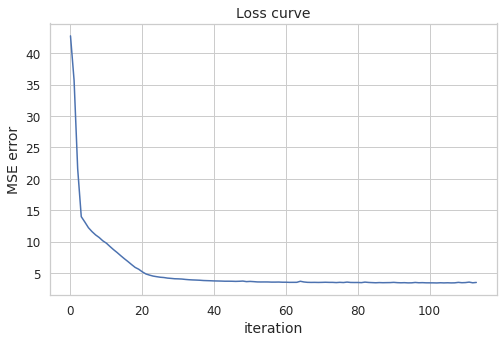

In [36]:
loss_values=model["neural_network"].loss_curve_
plt.plot(loss_values)
plt.title('Loss curve', fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('MSE error', fontsize=14)
plt.show()

#### Predict trên tập test

In [37]:
#tính độ lỗi trên tập test
test_preds = model.predict(test_X)*min_

test_preds= np.ceil(test_preds)

In [38]:
df = pd.DataFrame({'Actual price': test_y, 'Predicted price': test_preds})
df.head(10)

,Actual price,Predicted price
859,293000,444068.0
827,249950,265529.0
1600,413000,469331.0
605,250000,228238.0
615,377000,307432.0
228,429900,258144.0
1463,764500,683827.0
985,299900,211155.0
104,279900,284254.0
527,281990,184922.0


In [39]:
(test_preds-test_y).max()

528632.0

#### Độ chính xác trên tập test

In [40]:
compute_rr(test_y, test_preds, baseline_preds)

0.8606755300688531

### Linear Regression

#### Full pipeline

In [41]:
model = LinearRegression()
full_pipeline = Pipeline(steps=[('preprocess_pipeline', preprocess_pipeline),
                                 ('neural_network',model)])
full_pipeline

Pipeline(steps=[('preprocess_pipeline',
                 Pipeline(steps=[('numdropper', NumeDropper()),
                                 ('catedropper', CateDropper(n=4)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('nume',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['sqft',
                                                                    'beds',
                                                                    'baths',
                                                                    'tax']),
                                                                  ('cate',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['homeType',
                                                                    'heating_system',
                                                                    'cooling_system',
                                                                    'architecture_style'])])),
                                 ('minmax', MaxAbsScaler())])),
                ('neural_network', LinearRegression())])

#### Tìm N
Vói N là sô lượng các giá trị xuất hiện nhiều nhất sao cho độ lỗi trên tập validation là nhỏ nhất

In [42]:
train_errs = []
best_val_err = float('inf')
val_errs = []

best_N = None
N = [1,2,3,4,5,6]
for i in N:
    model = full_pipeline.set_params(preprocess_pipeline__catedropper__n=i).fit(train_X, train_y)
    train_error = compute_mse(train_y, model.predict(train_X))
    val_error = compute_mse(val_y, model.predict(val_X))
    
    train_errs.append(train_error)
    val_errs.append(val_error)
    
    if val_errs[-1] < best_val_err:
        best_val_err = val_errs[-1]
        best_N = i

#### Visualize validation error bởi các N khác nhau

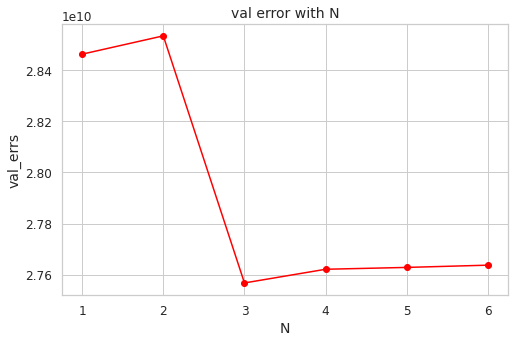

In [43]:
plt.plot(N, val_errs, color='red', marker='o')
plt.title('val error with N', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('val_errs', fontsize=14)
plt.show()

#### Train model 

In [44]:
train_X_merge = pd.concat([train_X, val_X_noOL])
train_y_merge = pd.concat([train_y, val_y_noOL])

In [45]:
model = full_pipeline.set_params(preprocess_pipeline__catedropper__n=best_N).fit(train_X_merge, train_y_merge)

#### Predict trên tập test

In [46]:
test_preds = model.predict(test_X)
test_preds = np.ceil(test_preds)

In [47]:
df = pd.DataFrame({'Actual price': test_y, 'Predicted price': test_preds})
df.head(10)

,Actual price,Predicted price
859,293000,438225.0
827,249950,262611.0
1600,413000,484624.0
605,250000,230620.0
615,377000,350017.0
228,429900,352074.0
1463,764500,790174.0
985,299900,246102.0
104,279900,259264.0
527,281990,194493.0


#### Độ chính xác trên tập test

In [48]:
compute_rr(test_y, test_preds, baseline_preds)

0.8572486363776716

### Nhận xét kết quả

**Kết quả chung:**
Phần lớn trong quá trình chạy, mô hình cho độ đo $r^{2}$ khoảng từ 0.5 đến 0.8 trên tập Test. \
Tuy nhiên mô hình cũng từng cho $r^2$ kết quả âm mặc dù rất hiếm. Theo nhóm, trường hợp này xảy ra vì trong tập Test được lựa chọn ngẫu nhiên và đã xuất hiện outlier có khoảng cách dự đoán so với giá trị thật rất xa.

**Giữa 2 mô hình:**

- MLP là mô hình phi tuyến tính, ban đầu nhóm hi vọng mô hình cho ra kết quả tốt hơn so với mô hình Linear Regression.
- Kết quả cho thấy Linear Regression ổn định hơn. 
- MLP không tốt bằng có thể do dữ liệu phân phố không đều và chưa đủ để mô hình có thể dự đoán giá nhà tốt. Dữ liệu hiện đang tập trung vào tầm giá thấp nên MLP optimize nhiều vào tầm giá đó.

## Reflection

### Lư Ngọc Liên - 18127046


#### Khó khăn
- Trong việc sử dụng Selenium (gặp nhiều lỗi vặt của webdriver)
- Phần lập trình liên quan đến visual dữ liệu
- Tìm cách chuẩn hóa dữ liệu để có được một 1 mô hình tốt hơn

#### Bài học đã học được
- Hiểu được rõ hơn về quy trình tiền xử lý dữ liệu
- Làm một bài toán từ đầu đến cuối from scratch
- Thông thạo hơn về việc visualize dữ liệu
- Làm việc nhóm từ xa (Pair Programming)

### Nguyễn Thị Anh Đào - 18127272

#### Khó khăn
- Khó nhất ở việc cải thiện mô hình, có nhiều giả thiết cho một mô hình không hoạt động tốt.\
    Đồng thời có nhiều phương pháp khác nhau để cải thiện, khó nhận biết được phương pháp phù hợp. 
- Chưa thành thạo sử dụng các thư viện như sklearn, seaborn 

#### Bài học đã học được
- Hiểu được rõ hơn về quy trình khai thác dữ liệu 
- Được thực hành nhiều về các thư viện: pandas, sklearn, seaborn
- Làm việc nhóm từ xa (Pair Programming)

### Nếu có thời gian
**Thu thập dữ liệu**:
- Lấy thêm mẫu cho các tầm giá trung bình và lớn, để cột output có phân phối đều hơn

**Tiền xử lý**:
- Chia các cột dạng số thành nhiều bin
- Tìm hiểu kĩ hơn về lĩnh vực bất động sản - buôn bán nhà đất, từ đó chọn ra các thuộc tính có sức ảnh hưởng nhất tới dự đoán giá nhà
- Tìm hiểu các phương pháp điền giá trị thiếu tốt hơn 

**Mô hình hóa**:
- Thử các mạng học sâu hiện đại hơn 

## Nguồn tham khảo
- Cấu trúc bài tham khảo từ Homework 03 môn Nhập môn Khoa học Dữ Liệu (Trường đại học Khoa học Tự Nhiên)
- Phần code compute_rr: Bài 07-Demo.ipynb của thầy Trần Trung Kiên
- Wikipedia, 68-95-99.7 Rule, https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule , 10/9/2021